In [1]:
!pip install lifelines
!pip install pandas
!pip install numpy

     -------------------------------------- 409.4/409.4 kB 8.7 MB/s eta 0:00:00
     ---------------------------------------- 48.9/48.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 82.3/82.3 kB 4.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=28decffc1c46947c8a6c9983b4f1eb36105361ae04ec8545912d18a489cf0185
  Stored in directory: c:\users\owner\appdata\local\pip\cache\wheels\e4\30\15\a77aac970f4acc37b9bb9c7f56e73c7c85087f15ff0fb4720f
Successfully built autograd-gamma


In [2]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway, kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [281]:
df = pd.read_csv('./waitlist_kidney_brazil.csv', encoding='latin-1')

In [282]:
df.head()

,Id,date,age_at_list_registration,age_cat,time_on_Dialysis,race,sex,underline_disease,diabetes,Blood_type,...,Time_death,Transplant,Transplant_Y_N,X36MthsTx,Time_Tx,priorization,removed_list,razon_removed,time,event
0,4,2017-06-29,67,Maior.60,1.0,Branca,M,Outras,1,A,...,13,Não,Não,0,13.07,Não,Não,NaN,392,0
1,5,2008-11-03,58,18.a.60,4.0,Branca,M,Diabetes,0,A,...,69,Óbito Lista,Não,0,68.87,Não,Não,NaN,2066,2
2,6,2010-07-13,51,18.a.60,2.0,Branca,M,HAS,1,O,...,98,Não,Não,0,12.17,Não,Sim,Removido (suspenso > 365 dias),365,3
3,7,2011-10-03,52,18.a.60,17.0,Branca,M,Diabetes,0,O,...,83,Não,Não,0,12.17,Não,Sim,Removido (suspenso > 365 dias),365,3
4,8,2006-07-05,67,Maior.60,68.0,Parda,M,HAS,1,A,...,6,Óbito Lista,Não,0,6.47,Não,Não,NaN,194,2


In [283]:
df.replace(to_replace='Não', value='No', inplace=True)
df.replace(to_replace='Sim', value='Yes', inplace=True)
df.rename(columns={'anti.HBc':'anti_HBc', 'anti.HCV':'anti_HCV'}, inplace=True)

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48153 entries, 0 to 48152
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Id                          48153 non-null  int64  
 1   date                        48153 non-null  object 
 2   age_at_list_registration    48153 non-null  int64  
 3   age_cat                     48153 non-null  object 
 4   time_on_Dialysis            46817 non-null  float64
 5   race                        48153 non-null  object 
 6   sex                         48153 non-null  object 
 7   underline_disease           48153 non-null  object 
 8   diabetes                    48153 non-null  int64  
 9   Blood_type                  48153 non-null  object 
 10  number_transfusion          48153 non-null  int64  
 11  gestation                   48153 non-null  object 
 12  number_gestation            19464 non-null  float64
 13  prior_transplant            481

In [285]:
df['prior_transplant']

0         No
1         No
2         No
3        Yes
4         No
        ... 
48148     No
48149    Yes
48150     No
48151     No
48152     No
Name: prior_transplant, Length: 48153, dtype: object

In [286]:
df['date']=pd.to_datetime(df['date']) # string to datetime format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48153 entries, 0 to 48152
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          48153 non-null  int64         
 1   date                        48153 non-null  datetime64[ns]
 2   age_at_list_registration    48153 non-null  int64         
 3   age_cat                     48153 non-null  object        
 4   time_on_Dialysis            46817 non-null  float64       
 5   race                        48153 non-null  object        
 6   sex                         48153 non-null  object        
 7   underline_disease           48153 non-null  object        
 8   diabetes                    48153 non-null  int64         
 9   Blood_type                  48153 non-null  object        
 10  number_transfusion          48153 non-null  int64         
 11  gestation                   48153 non-null  object    

In [287]:
df['date']

0       2017-06-29
1       2008-11-03
2       2010-07-13
3       2011-10-03
4       2006-07-05
           ...    
48148   2004-12-29
48149   2004-05-25
48150   2009-02-11
48151   2017-11-16
48152   2015-05-06
Name: date, Length: 48153, dtype: datetime64[ns]

In [288]:
df.duplicated().sum()

0

In [289]:
df.isna().sum()

Id                                0
date                              0
age_at_list_registration          0
age_cat                           0
time_on_Dialysis               1336
race                              0
sex                               0
underline_disease                 0
diabetes                          0
Blood_type                        0
number_transfusion                0
gestation                         0
number_gestation              28689
prior_transplant                  0
number_prior_transplant           0
subregion                         0
cPRA                              0
cPRA_cat                          0
HLA_A1                            0
HLA_A2                            0
HLA_B1                            0
HLA_B2                            0
HLA_DR1                           0
HLA_DR2                           0
DR_00                             0
B_00                              0
A_00                              0
calculated_frequency_DR.f1  

In [290]:
df.isna().sum()/len(df)*100

Id                             0.000000
date                           0.000000
age_at_list_registration       0.000000
age_cat                        0.000000
time_on_Dialysis               2.774490
race                           0.000000
sex                            0.000000
underline_disease              0.000000
diabetes                       0.000000
Blood_type                     0.000000
number_transfusion             0.000000
gestation                      0.000000
number_gestation              59.578842
prior_transplant               0.000000
number_prior_transplant        0.000000
subregion                      0.000000
cPRA                           0.000000
cPRA_cat                       0.000000
HLA_A1                         0.000000
HLA_A2                         0.000000
HLA_B1                         0.000000
HLA_B2                         0.000000
HLA_DR1                        0.000000
HLA_DR2                        0.000000
DR_00                          0.000000


In [291]:
df.drop(columns=['razon_removed'], inplace=True)

In [292]:
df[df['sex']=='M']['number_gestation'].isna().sum()

28679

In [293]:
df['number_gestation']=np.where(df['number_gestation'].isna(), 0, df['number_gestation'])
df['number_gestation'].isna().sum()

0

In [294]:
df['time_on_Dialysis'].unique()

array([  1.,   4.,   2.,  17.,  68.,  18.,  29.,   7.,  10.,  12.,  14.,
       102.,   9.,  21.,   3.,  55.,  82.,   6.,   5.,  nan,  27.,  20.,
         8.,   0.,  98.,  24.,  71.,  19.,  83.,  16.,  23.,  25.,  15.,
        22.,  11.,  36.,  49., 101.,  78.,  46.,  30.,  57.,  63.,  43.,
       180.,  34.,  28.,  31.,  13.,  74.,  52.,  32.,  41.,  73.,  35.,
        72.,  39.,  65.,  88.,  56.,  92., 131.,  66.,  69., 158.,  40.,
        26., 122.,  42.,  89.,  33.,  53.,  37.,  54., 111.,  45.,  62.,
       110.,  59.,  51., 145., 147., 121.,  87.,  80., 100.,  47., 134.,
        44.,  77.,  79.,  38.,  58., 173., 118., 108.,  81.,  70.,  48.,
       165.,  90., 115.,  61.,  95.,  67., 106.,  50.,  86.,  75., 129.,
       128.,  64.,  93.,  85.,  94.,  60., 104.,  84., 109., 126.,  91.,
       105., 170., 143., 177., 138., 167., 142.,  76., 103., 130., 114.,
       119., 113., 163., 124., 159., 135.,  99., 125., 176., 169., 146.,
       120., 150., 144., 175., 117., 112., 127., 13

In [295]:
df['time_on_Dialysis'] = np.where(df['time_on_Dialysis'].isna(), 1, df['time_on_Dialysis'])
df['time_on_Dialysis'] = np.where(df['time_on_Dialysis']==0, 1, df['time_on_Dialysis'])
df['time_on_Dialysis'].unique()

array([  1.,   4.,   2.,  17.,  68.,  18.,  29.,   7.,  10.,  12.,  14.,
       102.,   9.,  21.,   3.,  55.,  82.,   6.,   5.,  27.,  20.,   8.,
        98.,  24.,  71.,  19.,  83.,  16.,  23.,  25.,  15.,  22.,  11.,
        36.,  49., 101.,  78.,  46.,  30.,  57.,  63.,  43., 180.,  34.,
        28.,  31.,  13.,  74.,  52.,  32.,  41.,  73.,  35.,  72.,  39.,
        65.,  88.,  56.,  92., 131.,  66.,  69., 158.,  40.,  26., 122.,
        42.,  89.,  33.,  53.,  37.,  54., 111.,  45.,  62., 110.,  59.,
        51., 145., 147., 121.,  87.,  80., 100.,  47., 134.,  44.,  77.,
        79.,  38.,  58., 173., 118., 108.,  81.,  70.,  48., 165.,  90.,
       115.,  61.,  95.,  67., 106.,  50.,  86.,  75., 129., 128.,  64.,
        93.,  85.,  94.,  60., 104.,  84., 109., 126.,  91., 105., 170.,
       143., 177., 138., 167., 142.,  76., 103., 130., 114., 119., 113.,
       163., 124., 159., 135.,  99., 125., 176., 169., 146., 120., 150.,
       144., 175., 117., 112., 127., 132.,  97., 13

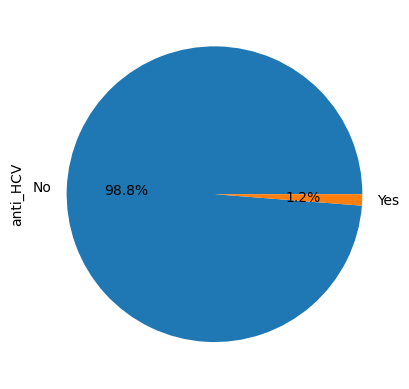

In [296]:
df['anti_HCV'].value_counts().plot(kind='pie', autopct='%1.1f%%');

In [297]:
df['anti_HCV'] = np.where(df['anti_HCV'].isna(), 'No', df['anti_HCV'])

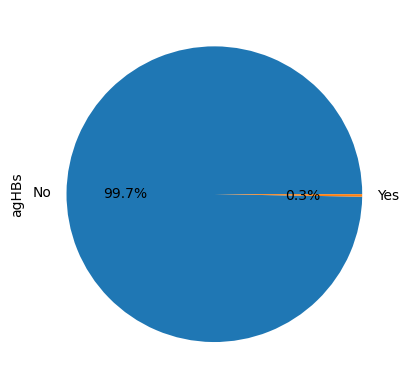

In [298]:
df['agHBs'].value_counts().plot(kind='pie', autopct='%1.1f%%');

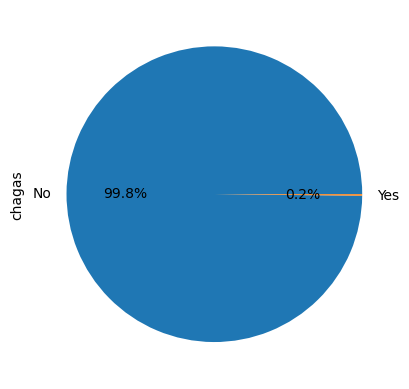

In [299]:
df['chagas'].value_counts().plot(kind='pie', autopct='%1.1f%%');

In [300]:
df.drop(columns=['agHBs', 'chagas'], inplace=True)
df.columns

Index(['Id', 'date', 'age_at_list_registration', 'age_cat', 'time_on_Dialysis',
       'race', 'sex', 'underline_disease', 'diabetes', 'Blood_type',
       'number_transfusion', 'gestation', 'number_gestation',
       'prior_transplant', 'number_prior_transplant', 'subregion', 'cPRA',
       'cPRA_cat', 'HLA_A1', 'HLA_A2', 'HLA_B1', 'HLA_B2', 'HLA_DR1',
       'HLA_DR2', 'DR_00', 'B_00', 'A_00', 'calculated_frequency_DR.f1',
       'calculated_frequency_DR.f2', 'calculated_frequency_DR.f',
       'calculated_frequency_B.f1', 'calculated_frequency_B.f2',
       'calculated_frequency_B.f', 'calculated_frequency_A.f1',
       'calculated_frequency_A.f2', 'calculated_frequency_A.f', 'anti_HBc',
       'anti_HCV', 'patient_still_on_list', 'date_acutal', 'death',
       'Time_death', 'Transplant', 'Transplant_Y_N', 'X36MthsTx', 'Time_Tx',
       'priorization', 'removed_list', 'time', 'event'],
      dtype='object')

In [301]:
df.isna().sum()

Id                            0
date                          0
age_at_list_registration      0
age_cat                       0
time_on_Dialysis              0
race                          0
sex                           0
underline_disease             0
diabetes                      0
Blood_type                    0
number_transfusion            0
gestation                     0
number_gestation              0
prior_transplant              0
number_prior_transplant       0
subregion                     0
cPRA                          0
cPRA_cat                      0
HLA_A1                        0
HLA_A2                        0
HLA_B1                        0
HLA_B2                        0
HLA_DR1                       0
HLA_DR2                       0
DR_00                         0
B_00                          0
A_00                          0
calculated_frequency_DR.f1    0
calculated_frequency_DR.f2    0
calculated_frequency_DR.f     0
calculated_frequency_B.f1     0
calculat

In [302]:
df['number_gestation'].sort_values()

0         0.0
28144     0.0
28145     0.0
28146     0.0
28147     0.0
         ... 
31923    22.0
44892    24.0
26735    35.0
28900    41.0
3512     63.0
Name: number_gestation, Length: 48153, dtype: float64

In [303]:
df['number_gestation'] = np.where(df['number_gestation']==63.0, 42.0, df['number_gestation'])
df['number_gestation'].sort_values()

0         0.0
28144     0.0
28145     0.0
28146     0.0
28147     0.0
         ... 
31923    22.0
44892    24.0
26735    35.0
28900    41.0
3512     42.0
Name: number_gestation, Length: 48153, dtype: float64

In [304]:
remove_list = []

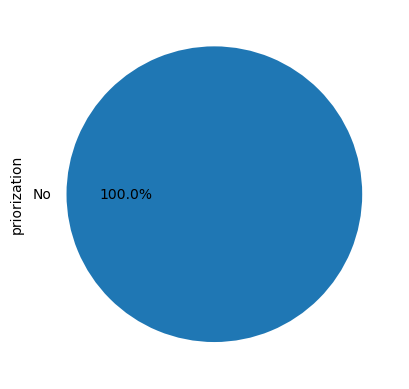

In [305]:
df['priorization'].value_counts().plot(kind='pie', autopct='%1.1f%%');

In [306]:
remove_list.append('priorization')

In [307]:
df['date_acutal'].unique()

array([43307], dtype=int64)

In [308]:
remove_list.append('date_acutal')

In [309]:
df['X36MthsTx'].unique()

array([0, 1], dtype=int64)

In [310]:
remove_list.append('X36MthsTx')

In [311]:
df['prior_transplant'].value_counts()

No     41983
Yes     6170
Name: prior_transplant, dtype: int64

In [312]:
df['number_prior_transplant'].value_counts() # less significant

0    41983
1     5428
2      630
3       94
4       14
5        4
Name: number_prior_transplant, dtype: int64

In [313]:
remove_list.append('number_prior_transplant')

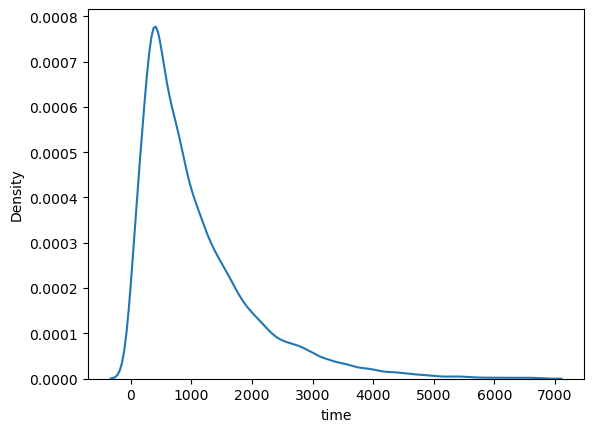

In [314]:
sns.kdeplot(data=df, x=df['time']); #scale metric=Days / higher range

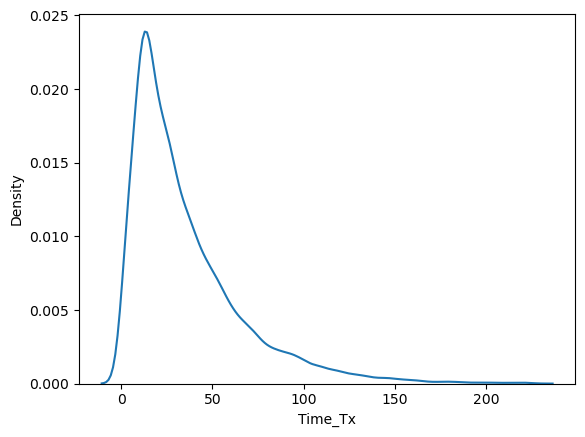

In [315]:
sns.kdeplot(data=df, x=df['Time_Tx']); # scale metric=Months / lower range

In [316]:
remove_list.append('time')

In [317]:
df['Transplant'].value_counts() # Óbito Lista = Death List

No             25289
Yes            13732
Óbito Lista     9132
Name: Transplant, dtype: int64

In [318]:
df.replace(to_replace='Óbito Lista', value='Death_List', inplace=True)
df['Transplant'].unique()

array(['No', 'Death_List', 'Yes'], dtype=object)

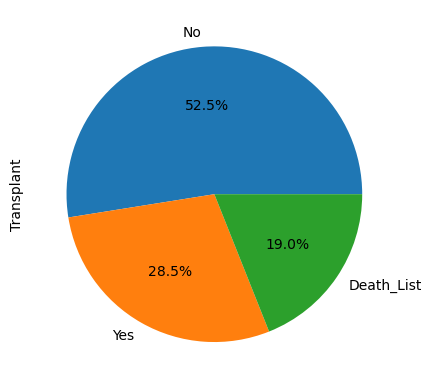

In [319]:
df['Transplant'].value_counts().plot(kind='pie', autopct='%1.1f%%');

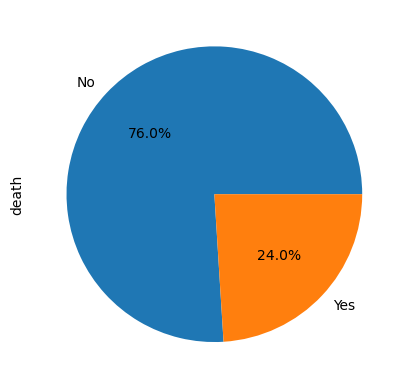

In [320]:
df['death'].value_counts().plot(kind='pie', autopct='%1.1f%%');

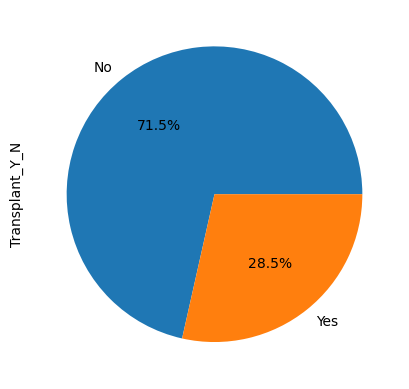

In [321]:
df['Transplant_Y_N'].value_counts().plot(kind='pie', autopct='%1.1f%%');

In [322]:
remove_list.append('Transplant')

In [323]:
df['gestation'].unique()

array(['No', 'Yes'], dtype=object)

In [324]:
df['number_gestation'].unique()

array([ 0.,  4.,  3.,  2., 12.,  5.,  1.,  7.,  6., 10., 14., 11.,  8.,
        9., 13., 42., 17., 18., 15., 35., 41., 16., 22., 20., 24.])

In [325]:
remove_list.append('number_gestation')

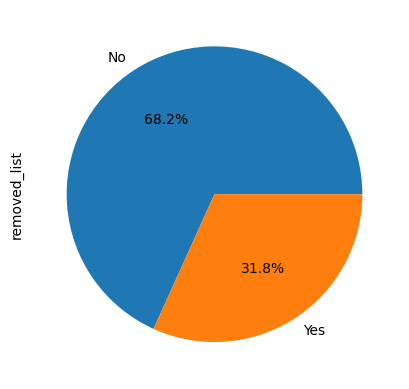

In [326]:
df['removed_list'].value_counts().plot(kind='pie', autopct='%1.1f%%');

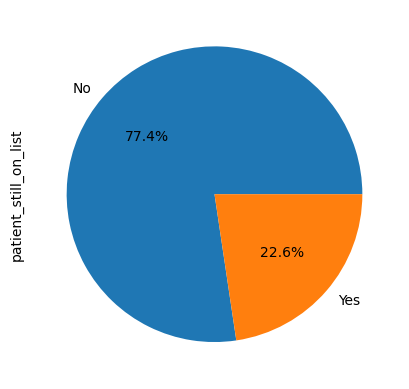

In [327]:
df['patient_still_on_list'].value_counts().plot(kind='pie', autopct='%1.1f%%');

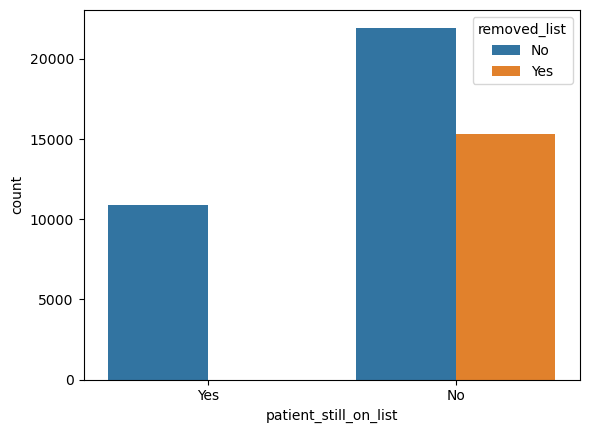

In [328]:
sns.countplot(x=df['patient_still_on_list'], hue=df['removed_list']);

In [329]:
remove_list.append('patient_still_on_list')

In [330]:
# removes local(brazil) features
hla_frequencies= ['calculated_frequency_DR.f1', 'calculated_frequency_DR.f2','calculated_frequency_DR.f', 'calculated_frequency_B.f1',\
                  'calculated_frequency_B.f2','calculated_frequency_B.f','calculated_frequency_A.f1','calculated_frequency_A.f2',\
                  'calculated_frequency_A.f']
remove_list.extend(hla_frequencies)

In [331]:
# removes local(brazil) features
remove_list.append('race')

In [332]:
# removes local(brazil) features
remove_list.append('subregion')

In [333]:
df['age_cat'].value_counts()

18.a.60     34752
Maior.60    11775
Menor.18     1626
Name: age_cat, dtype: int64

In [334]:
df['age_cat'].replace(to_replace= '18.a.60' , value= 'From18to60', inplace=True)
df['age_cat'].replace(to_replace= 'Maior.60' , value= 'Over60', inplace=True)
df['age_cat'].replace(to_replace= 'Menor.18' , value= 'Below18', inplace=True)

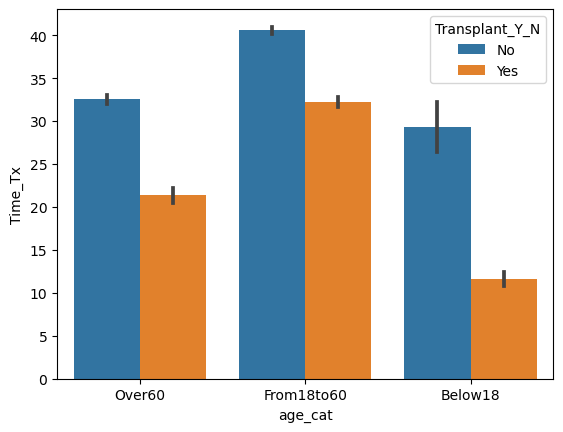

In [335]:
sns.barplot(data=df, x='age_cat', y='Time_Tx', hue='Transplant_Y_N');

In [336]:
df[['age_at_list_registration']].value_counts().sort_values()

age_at_list_registration
97                             1
95                             1
93                             1
91                             2
90                             2
                            ... 
55                          1367
52                          1372
53                          1384
57                          1404
56                          1445
Length: 95, dtype: int64

In [337]:
remove_list.append('age_at_list_registration')

In [338]:
df['cPRA_cat'].value_counts()

Zero           34205
Entre_0_50      7311
Maior_80        3895
Entre_50_80     2742
Name: cPRA_cat, dtype: int64

In [339]:
df['cPRA_cat'].replace(to_replace= 'Entre_0_50' , value= 'ZeroTo50', inplace=True)
df['cPRA_cat'].replace(to_replace= 'Entre_50_80' , value= 'From50To80', inplace=True)
df['cPRA_cat'].replace(to_replace= 'Maior_80' , value= 'Over80', inplace=True)

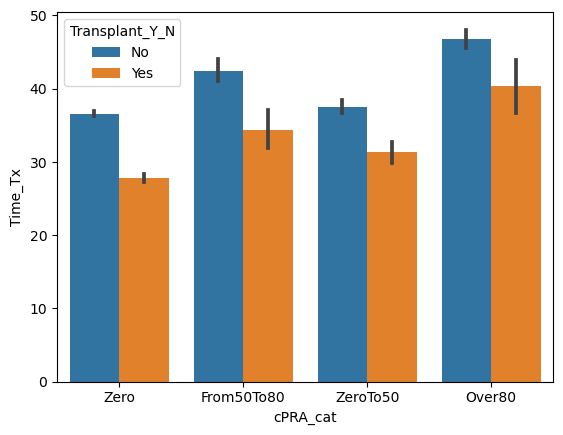

In [340]:
sns.barplot(data=df, x='cPRA_cat', y='Time_Tx', hue='Transplant_Y_N');

In [341]:
df['cPRA'].value_counts().sort_values() 
# Panel Reactive Antibody; 패널반응항체검사

66       50
59       51
48       54
46       64
72       67
      ...  
1       384
98      411
10      433
99      633
0     34205
Name: cPRA, Length: 101, dtype: int64

In [342]:
remove_list.append('cPRA')

In [343]:
df_cleaning = df.drop(columns=remove_list)
df_cleaning.columns

Index(['Id', 'date', 'age_cat', 'time_on_Dialysis', 'sex', 'underline_disease',
       'diabetes', 'Blood_type', 'number_transfusion', 'gestation',
       'prior_transplant', 'cPRA_cat', 'HLA_A1', 'HLA_A2', 'HLA_B1', 'HLA_B2',
       'HLA_DR1', 'HLA_DR2', 'DR_00', 'B_00', 'A_00', 'anti_HBc', 'anti_HCV',
       'death', 'Time_death', 'Transplant_Y_N', 'Time_Tx', 'removed_list',
       'event'],
      dtype='object')

In [344]:
drop_list=[]

In [345]:
# renaming features
renames={'underline_disease':'underlying_diseases',\
         'time_on_Dialysis':'dialysis_duration', 'Blood_type':'blood_group',\
         'number_transfusion':'blood_transfusions', 'Time_Tx':'waiting_time',\
         'Time_death':'time_death', 'Transplant_Y_N':'transplanted_or_not',\
         'sex':'gender', 'removed_list':'on_list_or_not' }
df_cleaning.rename(columns=renames, inplace=True)

In [346]:
df_cleaning['blood_transfusions'].value_counts()

0    31398
1    14427
2     1547
3      781
Name: blood_transfusions, dtype: int64

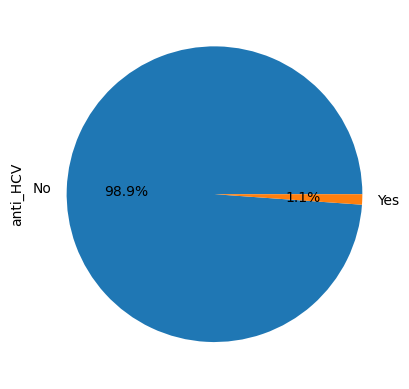

In [347]:
df_cleaning['anti_HCV'].value_counts().plot(kind='pie', autopct='%1.1f%%');

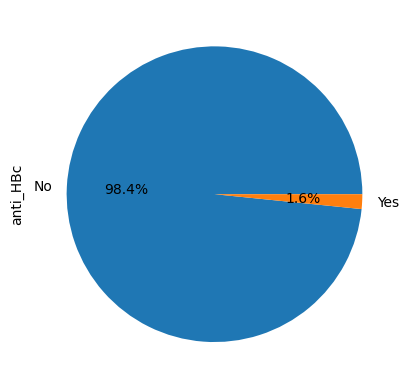

In [348]:
df_cleaning['anti_HBc'].value_counts().plot(kind='pie', autopct='%1.1f%%');

In [349]:
drops=['blood_transfusions', 'anti_HCV', 'anti_HBc']
drop_list.extend(drops)

In [350]:
df_cleaning['A_00'].value_counts()

heterozigoto    43171
homozigoto       4982
Name: A_00, dtype: int64

In [351]:
df_cleaning.replace(to_replace= 'homozigoto' , value= 'Homozygote', inplace=True)
df_cleaning.replace(to_replace= 'heterozigoto' , value= 'Heterozygote', inplace=True)

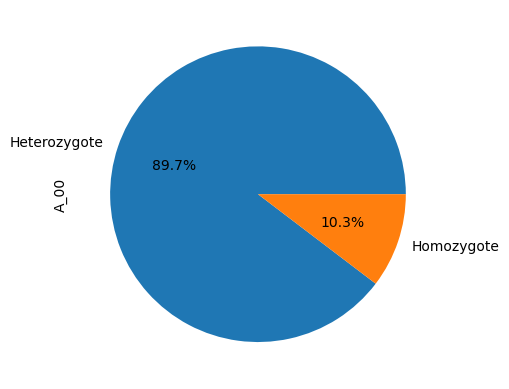

In [352]:
df_cleaning['A_00'].value_counts().plot(kind='pie', autopct='%1.1f%%');

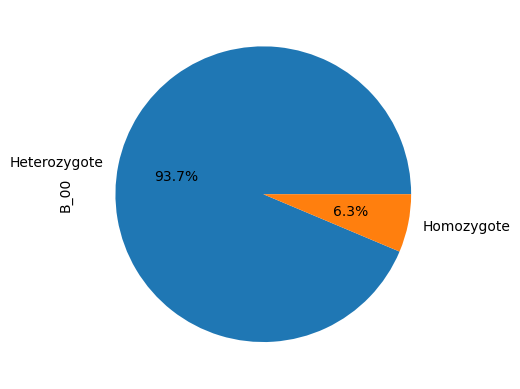

In [353]:
df_cleaning['B_00'].value_counts().plot(kind='pie', autopct='%1.1f%%');

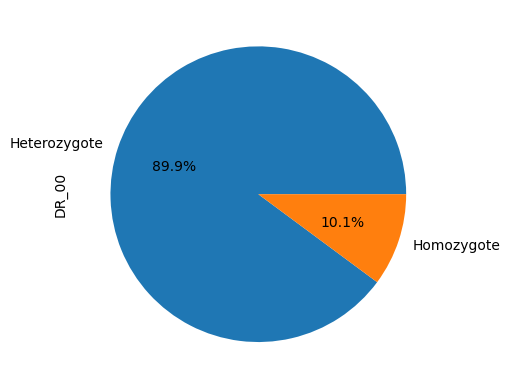

In [354]:
df_cleaning['DR_00'].value_counts().plot(kind='pie', autopct='%1.1f%%');

In [355]:
df_cleaning['underlying_diseases'].value_counts()

Outras          16626
HAS             13165
Diabetes         9987
GNC              7234
Pielonefrite     1141
Name: underlying_diseases, dtype: int64

In [356]:
df_cleaning.replace(to_replace= 'Outras' , value= 'others', inplace=True)
df_cleaning.replace(to_replace= 'HAS' , value= 'HUS', inplace=True)
# HUS: hemolytic uremic syndrome
df_cleaning.replace(to_replace= 'Diabetes' , value= 'diabetes', inplace=True)
df_cleaning.replace(to_replace= 'GNC' , value= 'GNS', inplace=True)
# N-acetylglucosamine-6-sulfatase / glucosamine (N-acetyl)-6-sulfatase
df_cleaning.replace(to_replace= 'Pielonefrite' , value= 'PN', inplace=True)
# pyelonephritis

In [357]:
df_cleaning['underlying_diseases'].unique()

array(['others', 'diabetes', 'HUS', 'GNS', 'PN'], dtype=object)

In [358]:
df_cleaning['diabetes'].value_counts()

1    38166
0     9987
Name: diabetes, dtype: int64

In [359]:
drop_list.append('diabetes')

In [360]:
df_cleaning['date'].value_counts()

2016-06-20    94
2012-12-03    82
2007-01-09    73
2010-10-06    73
2017-06-12    70
              ..
2013-06-26     1
2005-04-22     1
2012-02-20     1
2005-08-11     1
2002-01-13     1
Name: date, Length: 4108, dtype: int64

In [361]:
drop_list.append('date')

In [362]:
df_cleaning['death'].value_counts()

No     36592
Yes    11561
Name: death, dtype: int64

In [363]:
df_cleaning['time_death'].value_counts()

18     666
14     660
8      632
27     614
10     602
      ... 
198     43
183     43
172     38
226     34
201     22
Name: time_death, Length: 227, dtype: int64

In [364]:
df_cleaning['on_list_or_not'].value_counts()

No     32858
Yes    15295
Name: on_list_or_not, dtype: int64

In [365]:
df_cleaning['event'].value_counts()

3    14356
1    13732
0    10933
2     9132
Name: event, dtype: int64

In [366]:
drops2=['time_death', 'on_list_or_not', 'event']
drop_list.extend(drops2)

In [367]:
drop_list

['blood_transfusions',
 'anti_HCV',
 'anti_HBc',
 'diabetes',
 'date',
 'time_death',
 'on_list_or_not',
 'event']

In [368]:
df_cleaned=df_cleaning.drop(columns=drop_list)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48153 entries, 0 to 48152
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   48153 non-null  int64  
 1   age_cat              48153 non-null  object 
 2   dialysis_duration    48153 non-null  float64
 3   gender               48153 non-null  object 
 4   underlying_diseases  48153 non-null  object 
 5   blood_group          48153 non-null  object 
 6   gestation            48153 non-null  object 
 7   prior_transplant     48153 non-null  object 
 8   cPRA_cat             48153 non-null  object 
 9   HLA_A1               48153 non-null  int64  
 10  HLA_A2               48153 non-null  int64  
 11  HLA_B1               48153 non-null  int64  
 12  HLA_B2               48153 non-null  int64  
 13  HLA_DR1              48153 non-null  int64  
 14  HLA_DR2              48153 non-null  int64  
 15  DR_00                48153 non-null 

In [369]:
df_cleaned.head()

,Id,age_cat,dialysis_duration,gender,underlying_diseases,blood_group,gestation,prior_transplant,cPRA_cat,HLA_A1,...,HLA_B1,HLA_B2,HLA_DR1,HLA_DR2,DR_00,B_00,A_00,death,transplanted_or_not,waiting_time
0,4,Over60,1.0,M,others,A,No,No,Zero,1,...,44,51,3,7,Heterozygote,Heterozygote,Heterozygote,No,No,13.07
1,5,From18to60,4.0,M,diabetes,A,No,No,Zero,1,...,18,35,11,0,Homozygote,Heterozygote,Heterozygote,Yes,No,68.87
2,6,From18to60,2.0,M,HUS,O,No,No,From50To80,24,...,14,18,1,15,Heterozygote,Heterozygote,Heterozygote,No,No,12.17
3,7,From18to60,17.0,M,diabetes,O,No,Yes,ZeroTo50,24,...,14,18,1,15,Heterozygote,Heterozygote,Heterozygote,No,No,12.17
4,8,Over60,68.0,M,HUS,A,No,No,Zero,24,...,14,27,13,15,Heterozygote,Heterozygote,Heterozygote,Yes,No,6.47
